# Setup the model

In [1]:
import torch
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.transforms import (
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)

import copy

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:5: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  warnings.warn(
/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  warnings.warn(


This notebook uses *slowfast* network to extract features of video clips.
documentation about the model can be found at:
https://pytorch.org/hub/facebookresearch_pytorchvideo_slowfast/

This model processes batches of 32 frames each 256x256 pixels, and outputs a vector of 400 probabilities each belonging to one class of kinetics-400 dataset.

The above code follows the model presented in the following paper:
[1] Christoph Feichtenhofer et al, “SlowFast Networks for Video Recognition” https://arxiv.org/pdf/1812.03982.pdf

<img src="files/1.png" width="600">

In [2]:
# Load pretrained model
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

Using cache found in /home/yasamanparhizkar/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [3]:
# Set to GPU or CPU
device = 'cpu'
model = model.eval()
model = model.to(device)

In [4]:
# set model-specific parameters and transforms
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 1
frames_per_second = 60
slowfast_alpha = 4

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors. 
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform = Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    )

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second


# Setup the data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

# # Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

In [6]:
# load the fish movie
data_path = '../../data/original_files/'

frames = np.loadtxt(data_path + 'frames.csv', delimiter=',')
frames = frames.reshape(frames.shape[0], 120, 200)
print('frames.shape = {}'.format(frames.shape))

frames.shape = (1141, 120, 200)


In [7]:
# define a dataset object for the fish movie
class FishMovieDataset(Dataset):
    """Single frames of the fish movie"""

    def __init__(self, path, transform=None):
        """
        Input: path, nrn_i, transform
        path - path to where 'frames.csv' is stored
        transform - optional preprocessing on frames
        """
        
        frames = np.loadtxt(path + 'frames.csv', delimiter=',')
        frames = frames.reshape(frames.shape[0], 120, 200)
        
        self.frames = frames
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.numpy()
            sample = self.frames[idx]
            if self.transform:
                sample = torch.stack([self.transform(Image.fromarray(frm)) for frm in sample])
        
        else:
            sample = self.frames[idx]
            if self.transform:
                sample = self.transform(Image.fromarray(sample))

        return sample
    
    def frame_sz(self):
        return self.frames.shape[1:]
    
    def num_frames(self):
        return self.frames.shape[0]

In [8]:
# Get fish movie dataset with preprocessed frames
fmdata = FishMovieDataset(path=data_path,
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(256),
                               transforms.ToTensor()
                           ]))

## Create batches of frames with a dataloader

0 torch.Size([32, 1, 256, 256])
1 torch.Size([32, 1, 256, 256])
2 torch.Size([32, 1, 256, 256])
3 torch.Size([32, 1, 256, 256])


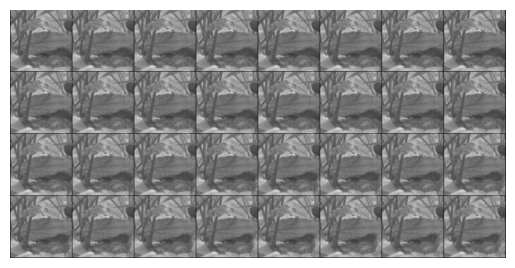

In [9]:
# iterate through batches of the movie of size 32 frames
dataloader = DataLoader(fmdata, batch_size=32,
                        shuffle=False, num_workers=0)


# Helper function to show a batch
def show_frames_batch(sample_batched):
    batch_size = len(sample_batched)
    im_size = sample_batched.size(2)
    grid_border_size = 2

    image_batched = torch.broadcast_to(sample_batched, (batch_size, 3, 256,256))/256
    grid = utils.make_grid(image_batched)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change "num_workers" to 0. 

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched.size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_frames_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Create batches of frames withOUT a dataloader

0 torch.Size([32, 1, 256, 256])


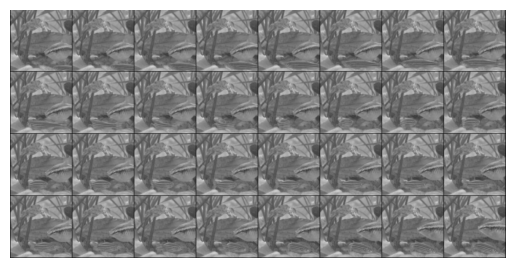

In [10]:
# idx = torch.tensor([1,3,3], dtype=torch.int32)
batch_st = 1000
batch_sz = 32
idx = torch.arange(batch_st, batch_st+batch_sz, dtype=torch.int32)
sample_batched = fmdata[idx]

print('0', sample_batched.size())
plt.figure()
show_frames_batch(sample_batched)
plt.axis('off')
plt.ioff()
plt.show()

## Evaluate the model for some sample inputs

In [11]:
# perform necessary preprocessing on a batch of 32 frames to be acceptable by the model
sample_batched = next(iter(dataloader))
sample_batched = torch.broadcast_to(sample_batched, (32, 3, 256,256))
sample_batched = sample_batched.transpose(0,1) # because a pytorch movie clip is describes as a tensor of shape (C, T, H, W)
inputs = transform(sample_batched)
# inputs is a list of two tensors: slow_pathway and fast_pathway movies. fast_pathway is just a subsample of slow_pathway

# Move the inputs to the desired device
inputs = [i.to(device)[None, ...] for i in inputs]

In [12]:
# Pass the input clip through the model
preds = model(inputs)
preds = preds.detach()

In [13]:
# Get the predicted classes
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=5).indices[0]

print(pred_classes)

tensor([ 23, 364,  66,  28, 299])


# Remove the top layer

In [14]:
# replace last fully connected layer with Identity
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [15]:
# copy the model so the original model doesn't change
model_t = copy.deepcopy(model)

# see layers of the model
# print(model_t)

# delete top layers
# model_t.blocks[5].dim = 0

model_t.blocks[6].dropout = Identity()
model_t.blocks[6].proj = Identity()
model_t.blocks[6].output_pool = Identity()

In [16]:
model_t.blocks[5].dim 

1

In [21]:
print(model_t)

Net(
  (blocks): ModuleList(
    (0): MultiPathWayWithFuse(
      (multipathway_blocks): ModuleList(
        (0): ResNetBasicStem(
          (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
          (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
        (1): ResNetBasicStem(
          (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
          (norm): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
      )
      (multipathway_fusion): FuseFastToSlow(
        (conv_fast_to_slow): Conv3d(8, 16, kernel_size=(7, 1, 1), st

## Evaluate new model (without the top layers)

In [18]:
# perform necessary preprocessing on a batch of 32 frames to be acceptable by the model
sample_batched = next(iter(dataloader))
sample_batched = torch.broadcast_to(sample_batched, (32, 3, 256,256))
sample_batched = sample_batched.transpose(0,1) # because a pytorch movie clip is describes as a tensor of shape (C, T, H, W)
inputs = transform(sample_batched)
# inputs is a list of two tensors: slow_pathway and fast_pathway movies. fast_pathway is just a subsample of slow_pathway

# Move the inputs to the desired device
inputs = [i.to(device)[None, ...] for i in inputs]

In [19]:
# Pass the input clip through the model
preds_t = model_t(inputs)
preds_t = preds_t.detach()

In [20]:
preds_t.size()

torch.Size([1, 9216])

## Evaluate the model for all batches in the movie
## Alternative title: compute feature vectors

### Save feature vectors

In [29]:
bath_sz = 32
dataset_sz = len(fmdata) - batch_sz + 1
# dataset_sz = 5

for batch_st in range(dataset_sz):
    idx = torch.arange(batch_st, batch_st+batch_sz, dtype=torch.int32)
    sample_batched = fmdata[idx]
    
    sample_batched = torch.broadcast_to(sample_batched, (32, 3, 256,256))
    sample_batched = sample_batched.transpose(0,1) # because a pytorch movie clip is describes as a tensor of shape (C, T, H, W)
    inputs = transform(sample_batched)
    inputs = [i.to(device)[None, ...] for i in inputs]
    
    preds = model_t(inputs)
    preds = preds.detach()
    torch.save(preds, '../../data/slowfast_9216/fv_'+str(batch_st)+'.pt')
    # print(batch_st, preds.size())

## Load feature vectors

In [16]:
# # load feature vectors - method 1
# fvs = []
# for vect_i in range(dataset_sz):
#     fvs.append(torch.load('../../data/slowfast_9216/fv_'+str(vect_i)+'.pt'))

# fvs = torch.cat(fvs)

In [26]:
# # load feature vectors - method 2
# fvs = torch.cat([torch.load('../../data/slowfast_9216/fv_'+str(vect_i)+'.pt') for vect_i in range(dataset_sz)])